# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [2]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [137]:
import numpy as np
import pandas as pd
import missingno as msno
import warnings
import time
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from yellowbrick.classifier import ClassificationReport

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<AxesSubplot:>

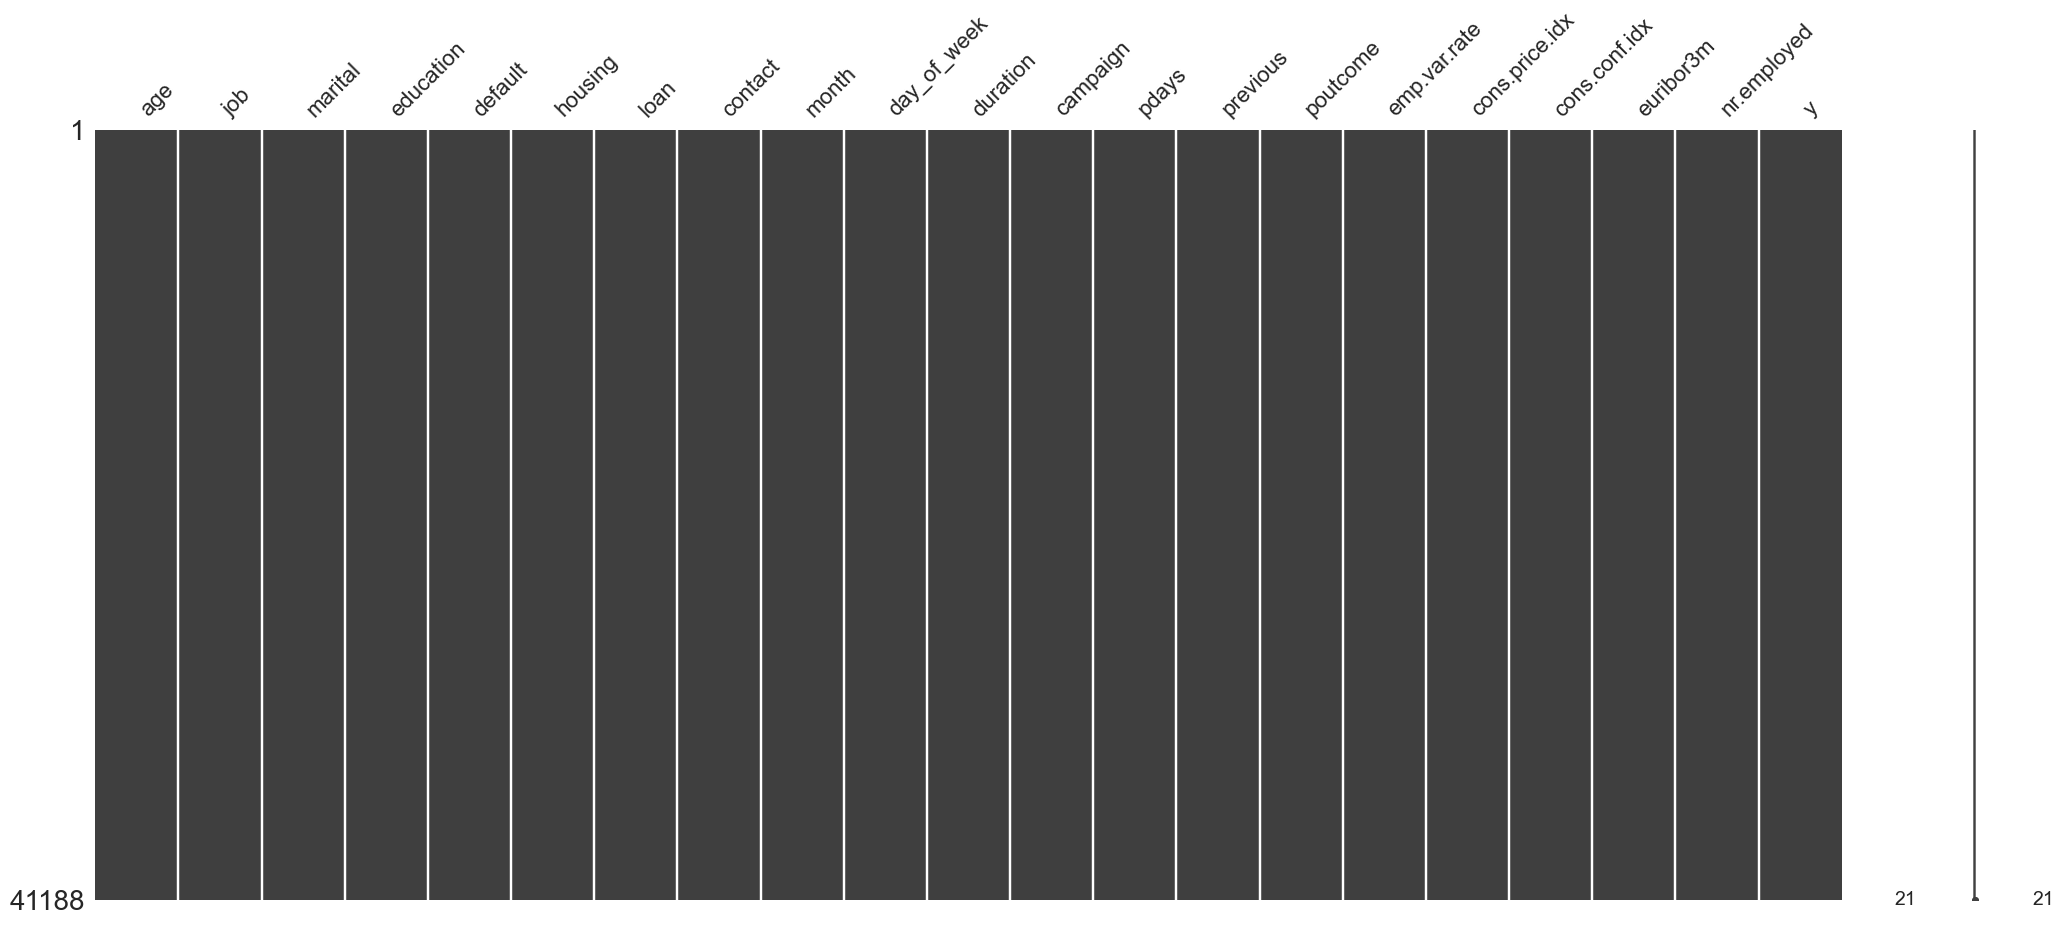

In [6]:
# using Missing Data python package on the df to visualize missing values
msno.matrix(df)

<AxesSubplot:>

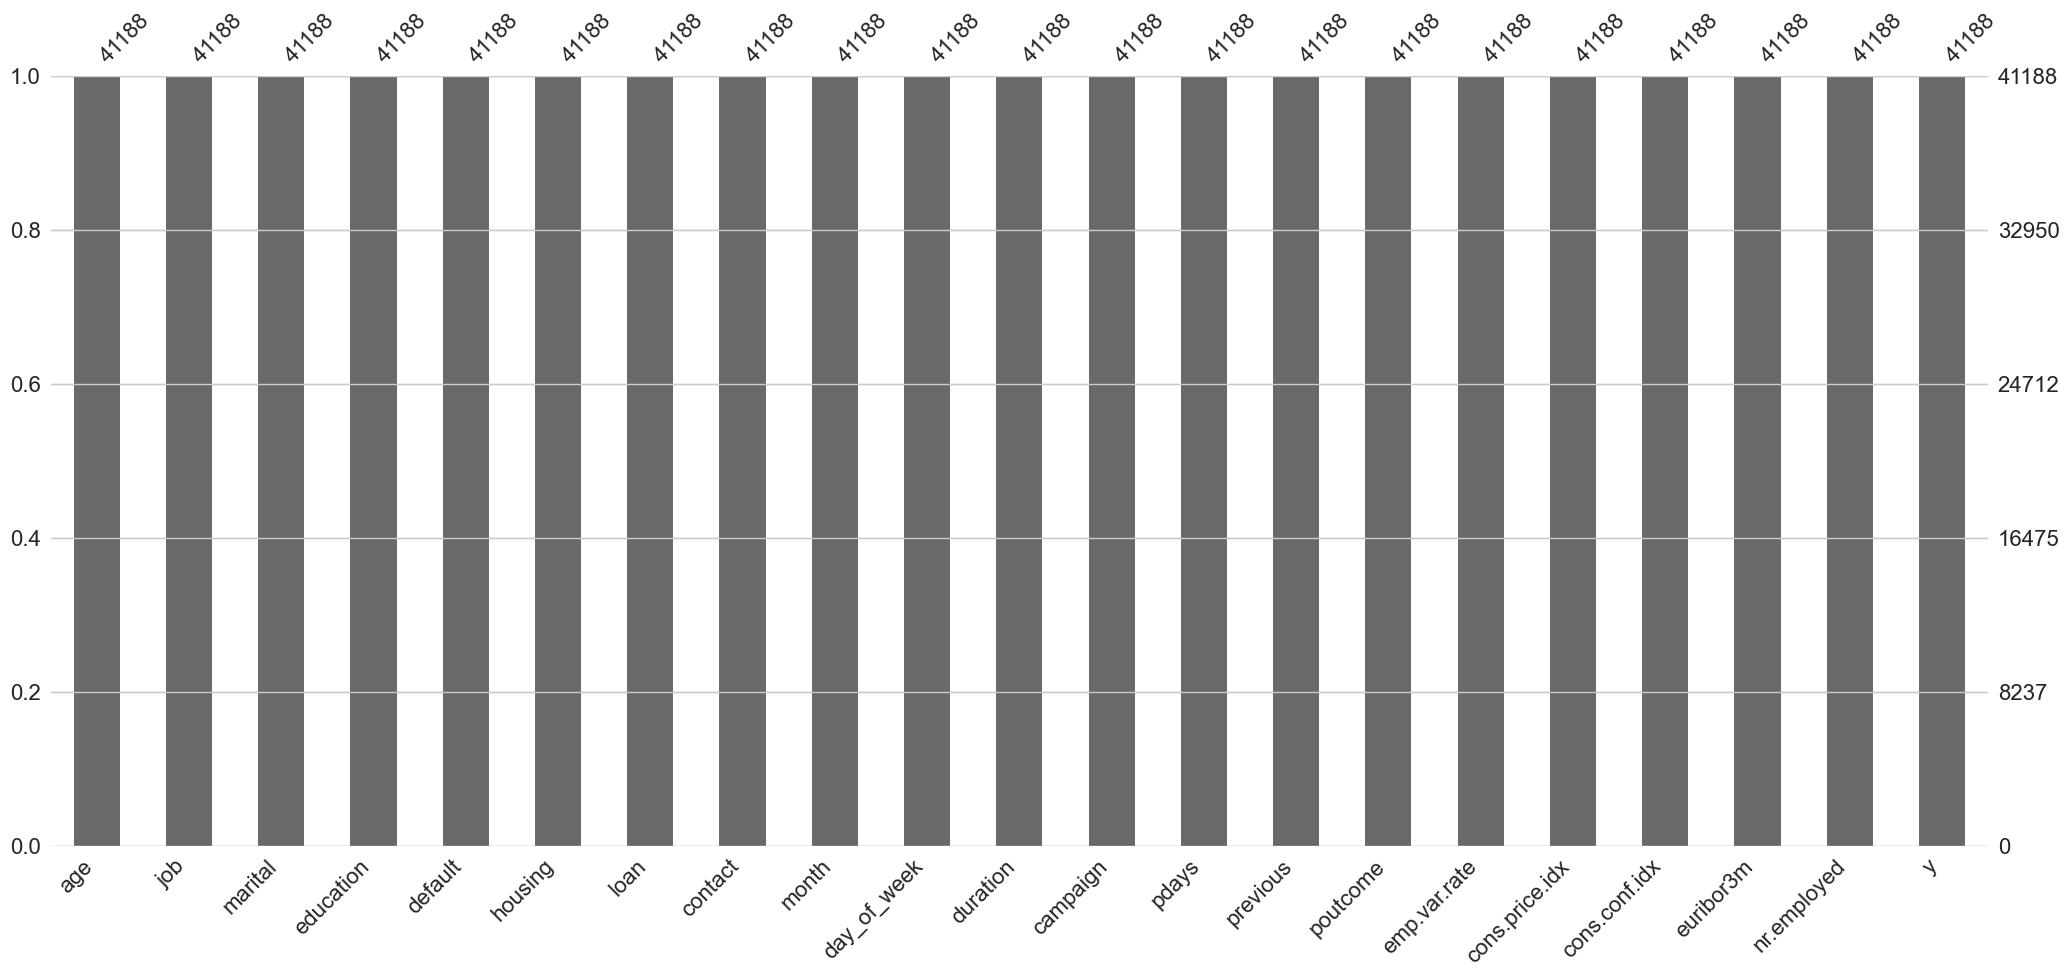

In [7]:
msno.bar(df)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

##### Objective Goes Here

<i>A well-trained ML model's objective is to predict accurately if the customer accepts an attractive long-term deposit application during a direct marketing campaign call.</i> 

In [8]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  Int64  
 1   job             41188 non-null  string 
 2   marital         41188 non-null  string 
 3   education       41188 non-null  string 
 4   default         41188 non-null  string 
 5   housing         41188 non-null  string 
 6   loan            41188 non-null  string 
 7   contact         41188 non-null  string 
 8   month           41188 non-null  string 
 9   day_of_week     41188 non-null  string 
 10  duration        41188 non-null  Int64  
 11  campaign        41188 non-null  Int64  
 12  pdays           41188 non-null  Int64  
 13  previous        41188 non-null  Int64  
 14  poutcome        41188 non-null  string 
 15  emp.var.rate    41188 non-null  Float64
 16  cons.price.idx  41188 non-null  Float64
 17  cons.conf.idx   41188 non-null 

In [9]:
# Checking for class imbalance
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: Int64

##### Visualizations ( using seaborne )

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
# Using SKLEARN LabelEncoder to encode columns : marital, education, loan, contact, month, day_of_week
df_encoded = df.apply(LabelEncoder().fit_transform)
df_encoded

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39,3,1,0,0,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
1,40,7,1,3,1,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
2,20,7,1,3,0,2,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
3,23,0,1,1,0,0,0,1,6,1,...,0,26,0,1,8,18,16,287,8,0
4,39,7,1,3,0,0,2,1,6,1,...,0,26,0,1,8,18,16,287,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,56,5,1,5,0,2,0,0,7,0,...,0,26,0,1,5,25,0,171,0,1
41184,29,1,1,5,0,0,0,0,7,0,...,0,26,0,1,5,25,0,171,0,0
41185,39,5,1,6,0,2,0,0,7,0,...,1,26,0,1,5,25,0,171,0,0
41186,27,9,1,5,0,0,0,0,7,0,...,0,26,0,1,5,25,0,171,0,1


In [11]:
data, target = df_encoded.drop(columns = 'y'), df_encoded.y

In [12]:
# SMOTE to handle class imbalance
os = SMOTE()
X, y = os.fit_resample(data, target)
y.value_counts()

0    36548
1    36548
Name: y, dtype: int64

In [13]:
# Pandas-Profiling
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### Statistical Analysis of the dataset

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Problem 7: A Baseline Model

In [131]:
# A baseline model is one in which we can always guess the most frequently occurring class.
baseline = df['y'].value_counts(normalize = True)[0]
print(f"Baseline performance (most frequently occuring class): {baseline}")

Baseline performance (most frequently occuring class): 0.8873458288821987


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [142]:
model = LogisticRegression()

### Problem 9: Score the Model

What is the accuracy of your model?

In [171]:
def score_model(X, y, model):
    model.fit(X, y)
    expected  = y
    predicted = model.predict(X)

    return accuracy_score(expected, predicted)

In [172]:
print("Training Accuracy Score: ", score_model(X_train, y_train, model))
print("Test Accuracy Score: ", score_model(X_test, y_test, model))

*** Logistic Regression *** 
Training Accuracy Score:  0.86246397431688
Test Accuracy Score:  0.8593083068840977


#### Conclusion: LogisticRegression is performing well on both the train & test data with almost identical accuracy scores.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

##### Visual Model Evaluation using YellowBrick Package

In [107]:
models = [
    LogisticRegression(), SVC(gamma='auto'), KNeighborsClassifier(), DecisionTreeClassifier()
]

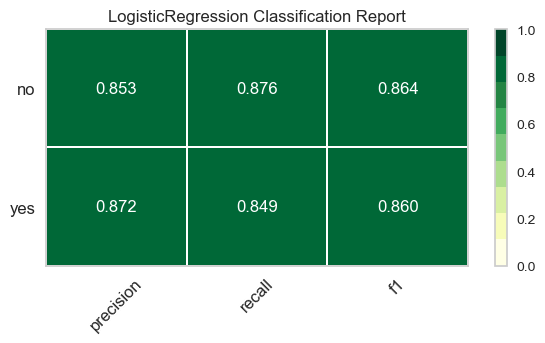

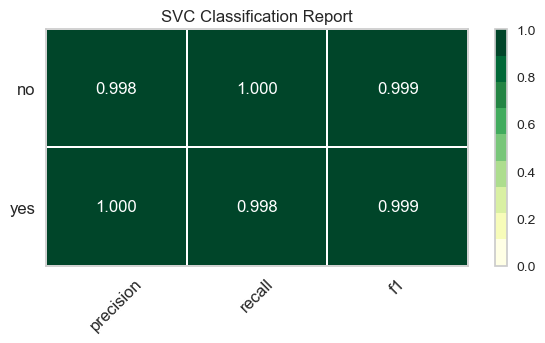

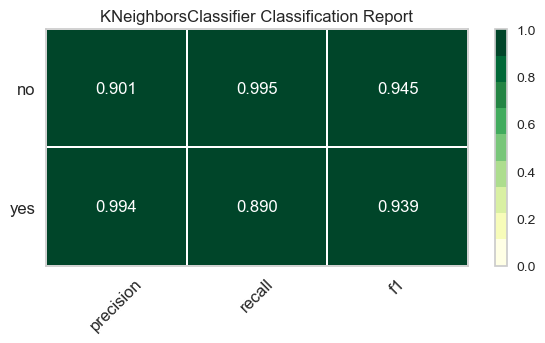

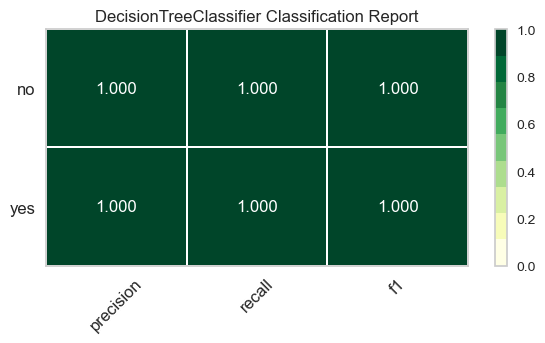

In [85]:
def visualize_model(X, y, estimator, **kwargs):

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['yes', 'no'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X_train, y_train, model)

In [175]:
def model_compare_matrix(X, y, model):
    model.fit(X, y)
    expected  = y
    predicted = model.predict(X)
    
    return accuracy_score(expected, predicted)

In [176]:
%%time
logreg_model = LogisticRegression()
logreg_train_accuracy = model_compare_matrix(X_train, y_train, logreg_model)

CPU times: user 1.21 s, sys: 26.6 ms, total: 1.23 s
Wall time: 342 ms


In [177]:
logreg_test_accuracy = model_compare_matrix(X_test, y_test, logreg_model)

In [178]:
%%time
svc_model = SVC(gamma='auto')
svc_train_accuracy = model_compare_matrix(X_train, y_train, svc_model)

CPU times: user 16min 44s, sys: 3.11 s, total: 16min 47s
Wall time: 16min 52s


In [179]:
svc_test_accuracy = model_compare_matrix(X_test, y_test, svc_model)

In [180]:
%%time
knn_model = KNeighborsClassifier()
knn_train_accuracy = model_compare_matrix(X_train, y_train, knn_model)

CPU times: user 1min 5s, sys: 20.3 s, total: 1min 25s
Wall time: 1min 1s


In [181]:
knn_test_accuracy = model_compare_matrix(X_test, y_test, knn_model)

In [182]:
%%time
dtc_model = DecisionTreeClassifier()
dtc_train_accuracy = model_compare_matrix(X_train, y_train, dtc_model)

CPU times: user 369 ms, sys: 3.14 ms, total: 372 ms
Wall time: 375 ms


In [183]:
dtc_test_accuracy = model_compare_matrix(X_test, y_test, dtc_model)

In [186]:
df_results = {
    'Model': ['LogisticRegression', 'SVC', 'KNN', 'DecisionTree'],
    'Train Time': ['1.23s','16min 47s','1m 25s','372 ms'],
    'Train Accuracy': [logreg_train_accuracy,svc_train_accuracy,knn_train_accuracy,dtc_train_accuracy],
    'Test Accuracy': [logreg_test_accuracy,svc_test_accuracy,knn_test_accuracy,dtc_test_accuracy]
}

findings = pd.DataFrame(df_results)
findings

,Model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1.23s,0.862464,0.859308
1,SVC,16min 47s,0.998887,0.999179
2,KNN,1m 25s,0.942560,0.923334
3,DecisionTree,372 ms,1.000000,1.000000


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Feature Engineering

##### LogisticRegression GridSearchCV

In [109]:
%%time
params = {
    'lr__penalty' : ['l1','l2'], 
    'lr__C'       : np.logspace(-3,3,7),
    'lr__solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

logreg_pipe = Pipeline([('scale', StandardScaler()),
                     ('lr', LogisticRegression(random_state=42, max_iter = 1000))])
logreg_grid = GridSearchCV(logreg_pipe,            
                   param_grid = params,       
                   scoring='accuracy').fit(X_train, y_train)

best_logreg_params = logreg_grid.best_params_
best_train_score = logreg_grid.score(X_train, y_train)
best_test_score = logreg_grid.score(X_test, y_test)

print(f'Best parameters for logreg:", best_logreg_params)
print(f'The training accuracy score is: {best_train_score}')
print(f'The test accuracy score is: {best_test_score}')

Best logreg params : {'lr__C': 1.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
The training accuracy score is: 0.880485936302944
The test accuracy score is: 0.8786800919338952
CPU times: user 1min 31s, sys: 3.42 s, total: 1min 35s
Wall time: 32.5 s


In [125]:
logreg = {
    'Model': ['LogisticRegression'],
    'Train Time': ['1min 35s'],
    'Train Accuracy': [0.8804],
    'Test Accuracy': [0.8787]
}

df_logreg = pd.DataFrame(logreg)

##### SVC GridSearchCV

In [113]:
%%time
params = {
    'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}

svc_pipe = Pipeline([
    ('std', StandardScaler()),
    ('model', SVC()),
])

svc_grid = GridSearchCV(svc_pipe, param_grid=params, scoring='accuracy').fit(X_train, y_train)

svc_train_acc = svc_grid.score(X_train, y_train)
svc_test_acc = svc_grid.score(X_test, y_test)
best_params = svc_grid.best_params_

print(f'Best parameters for SVC: {best_params}')
print(f'The training accuracy score is: {svc_train_acc: .2f}')
print(f'The test accuracy score is: {svc_test_acc: .2f}')

The training recall score is:  0.95
The test recall score is:  0.95
Best parameters of tree: {'model__kernel': 'rbf'}
CPU times: user 18min 58s, sys: 6.34 s, total: 19min 5s
Wall time: 19min 8s


In [119]:
svc = {
    'Model': ['SVC'],
    'Train Time': ['19min 5s'],
    'Train Accuracy': [0.95],
    'Test Accuracy': [0.95]
}

df_svc = pd.DataFrame(svc)

##### KNN GridSearchCV

In [111]:
%%time
params = {
    'knn__n_neighbors': list(range(1, 20, 2))
}

knn_pipe = Pipeline([('scale', StandardScaler()),
                     ('knn', KNeighborsClassifier())])
knn_grid = GridSearchCV(knn_pipe, param_grid=params, scoring='accuracy').fit(X_train, y_train)

knn_train_acc = knn_grid.score(X_train, y_train)
knn_test_acc = knn_grid.score(X_test, y_test)
best_params = knn_grid.best_params_

print(f'Best parameters for KNN: {best_params}')
print(f'The training accuracy score is: {knn_train_acc: .2f}')
print(f'The test accuracy score is: {knn_test_acc: .2f}')

The training recall score is (balanced):  0.98
The test recall score is (balanced):  0.95
Best parameters of tree (balanced): {'knn__n_neighbors': 3}
CPU times: user 9min 26s, sys: 3min 11s, total: 12min 37s
Wall time: 9min 9s


In [120]:
knn = {
    'Model': ['KNN'],
    'Train Time': ['12min 37s'],
    'Train Accuracy': [0.98],
    'Test Accuracy': [0.95]
}

df_knn = pd.DataFrame(knn)

##### DecisionTreeClassifier GridSearchCV

In [114]:
%%time
params = {
    'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'max_depth': [2, 5, 10],
    'min_samples_split': [0.1, 0.2, 0.05]
}

grid = ''
grid_train_acc = ''
grid_test_acc = ''
best_params = ''

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), 
                    param_grid=params, 
                    scoring='recall').fit(X_train, y_train)

grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_

print(f'Best parameters for tree: {best_params}')
print(f'The training accuracy score is: {grid_train_acc: .2f}')
print(f'The test accuracy score is: {grid_test_acc: .2f}')

The training recall score is (balanced):  0.95
The test recall score is (balanced):  0.95
Best parameters of tree (balanced): {'max_depth': 5, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.1}
CPU times: user 11.4 s, sys: 361 ms, total: 11.7 s
Wall time: 11.7 s


In [121]:
dtc = {
    'Model': ['DecisionTreeClassifier'],
    'Train Time': ['11.7s'],
    'Train Accuracy': [0.95],
    'Test Accuracy': [0.95]
}

df_dtc = pd.DataFrame(dtc)

In [124]:
df_tuned_findings = pd.concat([df_logreg,df_svc,df_knn,df_dtc])
df_tuned_findings

,Model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,1min 35s,0.8804,0.8787
0,SVC,19min 5s,0.9500,0.9500
0,KNN,12min 37s,0.9800,0.9500
0,DecisionTreeClassifier,11.7s,0.9500,0.9500


#### Performance Metrics

##### Questions

In [28]:
# Correctly identify a client who has subscribed to a term deposit

### Visualizations & Model Selection using YellowBrick

In [ ]:
from yellowbrick.features import ParallelCoordinates
visualizer = ParallelCoordinates()
visualizer.fit_transform(X, y)
visualizer.show()